In [647]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


In [648]:
# Creates the features
regress_data = pd.read_csv(open("all_features.csv", 'rU'), encoding='utf-8', engine='c')
regress_data = regress_data.drop('Unnamed: 0', 1)
regress_data = regress_data.drop('Unnamed: 0.1', 1)
regress_data = regress_data.drop('Avg_Tweets', 1)
regress_data = regress_data.drop('is_Series_C', 1)
regress_data = regress_data.drop('is_Series_D', 1)
regress_data = regress_data.drop('is_Series_B', 1)
regress_data = regress_data.drop('is_Series_A', 1)
regress_data['Series'] = [val[1:] for val in list(regress_data['Series'])]
regress_data['i_Series_A'] = 1 * (regress_data.Series == 'Series_A')
regress_data['i_Series_B'] = 1 * (regress_data.Series == 'Series_B')
regress_data['i_Series_C'] = 1 * (regress_data.Series == 'Series_C')
regress_data['i_Series_D'] = 1 * (regress_data.Series == 'Series_D')
regress_data = regress_data.replace([np.inf, -np.inf], 0)
regress_data.fillna(0, inplace=True)

# Break it into test and train
itrain, itest = train_test_split(xrange(regress_data.shape[0]), train_size=0.9)
mask=np.ones(regress_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask=(mask==1)
regress_train = regress_data[mask]
regress_test = regress_data[~mask]

# Break it into series A, series B, series C, series D
regress_test_A = regress_test[regress_test['Series'] == 'Series_A']
regress_train_A = regress_train[regress_train['Series'] == 'Series_A']
regress_test_B = regress_test[regress_test['Series'] == 'Series_B']
regress_train_B = regress_train[regress_train['Series'] == 'Series_B']
regress_test_C = regress_test[regress_test['Series'] == 'Series_C']
regress_train_C = regress_train[regress_train['Series'] == 'Series_C']
regress_test_D = regress_test[regress_test['Series'] == 'Series_D']
regress_train_D = regress_train[regress_train['Series'] == 'Series_D']

regress_train.head()

,company_name,Series,Total_Likes,Total_Retweets,Series_Amount,Market,tweet_count,get_dayrange,get_dayiqr,likes_mean,...,is_Mobile,is_Web Hosting,mean_neg,mean_pos,total_neg,total_pos,i_Series_A,i_Series_B,i_Series_C,i_Series_D
1,2tor,Series_C,10,32,32500000,0,162,98,42,0.061728,...,False,False,0.018364,0.042564,0.000000,0.060606,0,0,1,0
2,365Scores,Series_B,15,23,5500000,Apps,163,1,1,0.092025,...,False,False,0.019701,0.046836,0.006329,0.006329,0,1,0,0
3,36Kr,Series_C,58,21,20000,Startups,173,83,43,1.312139,...,False,False,0.036364,0.058589,0.051546,0.077320,0,0,1,0
4,6fusion,Series_B,2,28,7000000,Hardware + Software,177,251,131,0.011299,...,False,False,0.021415,0.037837,0.000000,0.000000,0,1,0,0
5,6sense,Series_A,42,43,12000000,Invest Online,215,47,24,0.195349,...,False,False,0.032787,0.070523,0.016216,0.113514,1,0,0,0


This is the unstandardized dataset that we will be performing the regression on. We have approximately 46 features that we're running our regression on ranging from indiciator variables on the type of startup to variables that represent the average sentiment of the tweets.

In [649]:
# Create stats for each of the funding rounds
def find_stats(funding, label):
    print '------------------------------------'
    print 'Round: ' + label
    amounts = funding['Series_Amount']
    print 'Mean ' + str(np.mean(amounts))
    print 'StDev ' + str(np.std(amounts)) 
    
    
# Helps visualize the log of the funding rounds
def create_log_plot(regress_train_A, regress_train_B, regress_train_C, regress_train_D):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.tight_layout()
    round_title = ['Series A Funding Amounts', 'Series B Funding Amounts', 'Series C Funding Amounts', 'Series D Funding Amounts']
    rounds = [regress_train_A, regress_train_B, regress_train_C, regress_train_D]
    for ax, i in zip(axes.ravel(), range(len(rounds))):
        funding = np.log((list(rounds[i]['Series_Amount'])))
        ax.hist(funding, color='b', alpha=0.2)
        ax.set_title(round_title[i])

# Visualizes the residuals of the funding rounds
def plot_residuals(errors):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    fig.tight_layout()
    axes.hist(errors, color='b', alpha=0.2)
    axes.set_title('Residual Analysis')

As we showed before in our actual analysis, the actual valuation amount is very heavily skewed right. We can help change this by applying a log transform on the output data to make the output data more normal. The data after applying the log transform is shown below. This will help improve the ability of our regressors to detect correct values.

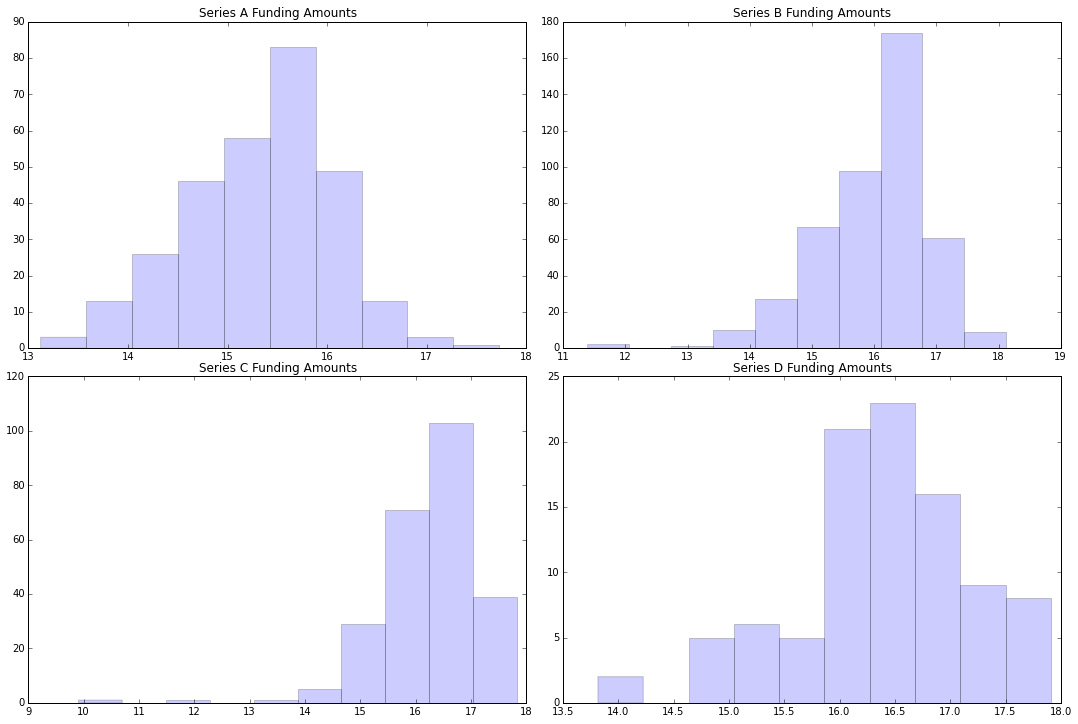

In [650]:
 create_log_plot(regress_train_A, regress_train_B, regress_train_C, regress_train_D)

We will now create our data matrices for the regressions that we run. We split the data into test and train sets. We then break the data into a data matrix and a response matrix. After this, we also transform the data matrices into float values.

In [651]:
features = list(regress_train_D.columns[2:])
features.remove('Market')
features.remove('Series_Amount')

X_train = np.asmatrix(regress_train[features].astype(np.float64))
X_test = np.asmatrix(regress_test[features].astype(np.float64))
y_train = np.asmatrix(regress_train['Series_Amount'].apply(lambda val: np.log(val))).T
y_test = np.asmatrix(regress_test['Series_Amount'].apply(lambda val: np.log(val))).T

Here we try ridge regression. As we learned in class, ridge regression has the following equation form:

.....

We try to determine the regularization parameters we want to use. In order to limit issues, we use KFold cross validation to find this parameter and make sure that we are not incorrectly learning parameters through regressions.

After this, we apply our model to the training data and compare the RMSE generated to our baseline model. 

In [675]:
vdict = {}
rdict = {}
for a in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    for cv_train, cv_test in KFold(y_train.size, 5):
        lin_model_r = Ridge(alpha=a)
        lin_model_r.fit(X_train[cv_train], y_train[cv_train])
        y_pred = np.asmatrix(lin_model_r.predict(X_train[cv_test])).T
        mse = (mean_squared_error(y_train[cv_test], y_pred.T)**(0.5))
        vdict[a] = mse
        rdict[a] = lin_model_r
        
best_a = min(vdict, key=vdict.get)
best_ridge_model =rdict[best_a]

print 'Cross validation MSE values: ' + str(vdict)
print 'Best a from cross validation: ' + str(best_a)

Cross validation MSE values: {1: 0.86330209125190971, 100: 0.86298521236834758, 0.1: 0.86844646484945787, 1000: 0.91862897822313561, 10: 0.8559995174877898, 0.001: 0.8772632633082651, 10000: 0.94433758132905887, 0.01: 0.87485828803568688}
Best a from cross validation: 10


In [676]:
y_pred = np.asmatrix(best_ridge_model.predict(X_test)).T
mse = (mean_squared_error(y_test, y_pred.T)**(0.5))
baseline_mean = np.log(np.asmatrix(np.mean(regress_test['Series_Amount']) * np.ones(y_test.shape[0]))).T

print 'RMSE for Ridge Regression: ' + str(mse)
print 'Baseline by predicting averages RMSE: ' + str(mean_squared_error(y_test, baseline_mean)**(0.5))

RMSE for Ridge Regression: 0.816413409842
Baseline by predicting averages RMSE: 0.965587980545


Let's plot the residuals to see if our assumption that the remaining noise is approximately normal is true. This is one of the key assumptions of linear regression analysis. Additionally, let's determine the R squared score. 

R Squared Score: 0.16378831318


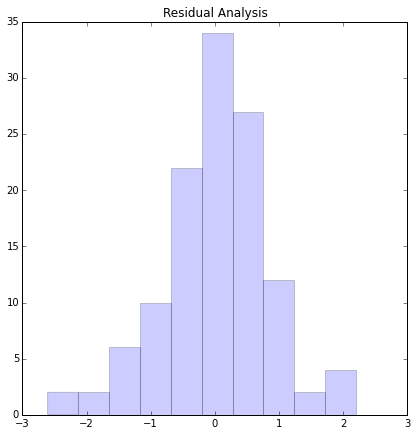

In [677]:
plot_residuals(y_test-y_pred.T)
print 'R Squared Score: ' + str(r2_score(y_test, y_pred.T))

As we might expect, we can see that the residuals are approximately normal in this dataset. However, when we calculate the R squared score, its relatively low. This means that the fit of the data is not particularly great. This suggests that linear regression is probably not the best way to model this data.

Using regressions, we perform better than the baseline model of simply predicting the average value. However, our relatively low R squared score suggests that linear regressions is not the most ideal way to predict these valuations.

We now try LASSO regression as well. This might perform a bit better than the Ridge regression because Lasso regression. Lasso regressions help move coeffecients to exactly zero because we are shrinking the regression coeffecients to zero. Lasso regressions follow the below equation

....

In this case, we might want to shrink the parameter regressions to zero because we have so many features that may not necessarily be related. 

In [678]:
vdict = {}
rdict = {}
for a in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    for cv_train, cv_test in KFold(y_train.size, 5):
        lin_model_r = Lasso(alpha=a)
        lin_model_r.fit(X_train[cv_train], y_train[cv_train])
        y_pred = np.asmatrix(lin_model_r.predict(X_train[cv_test])).T
        mse = (mean_squared_error(y_train[cv_test], y_pred)**(0.5))
        vdict[a] = mse
        rdict[a] = lin_model_r
        
best_a = min(vdict, key=vdict.get)
best_lasso_model =rdict[best_a]

print 'Cross validation MSE values: ' + str(vdict)
print 'Best a from cross validation: ' + str(best_a)

Cross validation MSE values: {1: 0.93827657445156609, 100: 0.95104995902476475, 0.1: 0.89967062297253808, 1000: 0.95104995902476475, 10: 0.94252105356280125, 0.001: 0.8546320590672084, 10000: 0.95104995902476475, 0.01: 0.8519369412998905}
Best a from cross validation: 0.01


In [682]:
y_pred = np.asmatrix(best_lasso_model.predict(X_test)).T
mse = (mean_squared_error(y_test, y_pred)**(0.5))
baseline_mean = np.log(np.asmatrix(np.mean(regress_test['Series_Amount']) * np.ones(y_test.shape[0]))).T

print 'RMSE for Lasso Regression: ' + str(mse)
print 'Baseline by predicting averages RMSE: ' + str(mean_squared_error(y_test, baseline_mean)**(0.5))

RMSE for Lasso Regression: 0.80433407259
Baseline by predicting averages RMSE: 0.965587980545


Similar to before, we can look at the residuals and determine the R squared score to see whether or not this model makes sense, and whether or not the data is fitting the model well.

R Squared Score: 0.188349787744


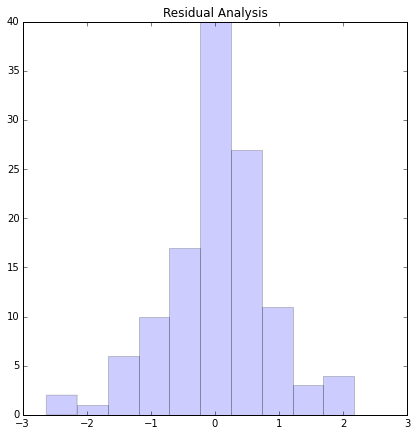

In [685]:
plot_residuals(y_test-y_pred)
print 'R Squared Score: ' + str(r2_score(y_test, y_pred))

In this case, we get a better RMSE using Lasso. Similar to before, our residuals look relatively normally distributed. The R squared value also suggests that there is some signal in the twitter data. 

This will serve as a baseline for u